# PCA and k-means

## Setting up

In [ ]:
"""
Author      : Yi-Chieh Wu, Sriram Sankararaman
"""
import time

# numpy and scipy libraries
import numpy as np
from scipy import stats

# matplotlib libraries
import matplotlib.pyplot as plt
import collections

In [ ]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
# Change the path below to the path where your folder locates
# where you have util.py
### ========== TODO : START ========== ###
sys.path.append('/content/drive/My Drive/cm146/pset4')
### ========== TODO : START ========== ###


In [ ]:
import util
from util import *

## Point, Cluster and Set of Clusters classes

In [ ]:
######################################################################
# classes
######################################################################

class Point(object) :

    def __init__(self, name, label, attrs) :
        """
        A data point.

        Attributes
        --------------------
            name  -- string, name
            label -- string, label
            attrs -- numpy arrray of shape (d, ) where d is the number of features
        """

        self.name = name
        self.label = label
        self.attrs = attrs


    #============================================================
    # utilities
    #============================================================

    def distance(self, other) :
        """
        Return Euclidean distance of this point with other point.

        Parameters
        --------------------
            other -- Point, point to which we are measuring distance

        Returns
        --------------------
            dist  -- float, Euclidean distance
        """
        # Euclidean distance metric
        return np.linalg.norm(self.attrs-other.attrs)


    def __str__(self) :
        """
        Return string representation.
        """
        return "%s : (%s, %s)" % (self.name, str(self.attrs), self.label)

In [ ]:
class Cluster(object) :

    def __init__(self, points) :
        """
        A cluster (set of points).

        Attributes
        --------------------
            points -- list of Points, cluster elements
        """
        self.points = points


    def __str__(self) :
        """
        Return string representation.
        """
        s = ""
        for point in self.points :
            s += str(point)
        return s

    #============================================================
    # utilities
    #============================================================

    def purity(self) :
        """
        Compute cluster purity.

        Returns
        --------------------
            n           -- int, number of points in this cluster
            num_correct -- int, number of points in this cluster
                                with label equal to most common label in cluster
        """
        labels = []
        for p in self.points :
            labels.append(p.label)

        cluster_label, count = stats.mode(labels)
        return len(labels), np.float64(count)


    def centroid(self) :
        """
        Compute centroid of this cluster.

        Returns
        --------------------
            centroid -- Point, centroid of cluster
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement
        # set the centroid label to any value (e.g. the most common label in this cluster)

        labels = [p.label for p in self.points]
        # Use np.atleast_1d to ensure we can index the result safely
        cluster_label = np.atleast_1d(stats.mode(labels).mode)[0]
        coords = np.mean([p.attrs for p in self.points], axis=0)
        return Point("centroid", cluster_label, coords)
        ### ========== TODO : END ========== ###



    def medoid(self) :
        """
        Compute medoid of this cluster, that is, the point in this cluster
        that is closest to all other points in this cluster.

        Returns
        --------------------
            medoid -- Point, medoid of this cluster
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement


        labels = [p.label for p in self.points]
        # Ensure the mode is an array so we can safely index it.
        cluster_label = np.atleast_1d(stats.mode(labels).mode)[0]

        best_point = None
        best_dist_sum = float('inf')

        # Iterate over each point and compute the total distance to all other points
        for p in self.points:
            dist_sum = sum(p.distance(q) for q in self.points)
            if dist_sum < best_dist_sum:
                best_dist_sum = dist_sum
                best_point = p

        # Return a new Point with the medoid's attributes and the most common label
        return Point("medoid", cluster_label, best_point.attrs)

        ### ========== TODO : END ========== ###


    def equivalent(self, other) :
        """
        Determine whether this cluster is equivalent to other cluster.
        Two clusters are equivalent if they contain the same set of points
        (not the same actual Point objects but the same geometric locations).

        Parameters
        --------------------
            other -- Cluster, cluster to which we are comparing this cluster

        Returns
        --------------------
            flag  -- bool, True if both clusters are equivalent or False otherwise
        """

        if len(self.points) != len(other.points) :
            return False

        matched = []
        for point1 in self.points :
            for point2 in other.points :
                if point1.distance(point2) == 0 and point2 not in matched :
                    matched.append(point2)
        return len(matched) == len(self.points)

In [ ]:
class ClusterSet(object):

    def __init__(self) :
        """
        A cluster set (set of clusters).

        Parameters
        --------------------
            members -- list of Clusters, clusters that make up this set
        """
        self.members = []


    #============================================================
    # utilities
    #============================================================

    def centroids(self) :
        """
        Return centroids of each cluster in this cluster set.

        Returns
        --------------------
            centroids -- list of Points, centroids of each cluster in this cluster set
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement

        return [cluster.centroid() for cluster in self.members]

        ### ========== TODO : END ========== ###


    def medoids(self) :
        """
        Return medoids of each cluster in this cluster set.

        Returns
        --------------------
            medoids -- list of Points, medoids of each cluster in this cluster set
        """

        ### ========== TODO : START ========== ###
        # part 2b: implement

        return [cluster.medoid() for cluster in self.members]

        ### ========== TODO : END ========== ###


    def score(self) :
        """
        Compute average purity across clusters in this cluster set.

        Returns
        --------------------
            score -- float, average purity
        """

        total_correct = 0
        total = 0
        for c in self.members :
            n, n_correct = c.purity()
            total += n
            total_correct += n_correct
        return total_correct / float(total)


    def equivalent(self, other) :
        """
        Determine whether this cluster set is equivalent to other cluster set.
        Two cluster sets are equivalent if they contain the same set of clusters
        (as computed by Cluster.equivalent(...)).

        Parameters
        --------------------
            other -- ClusterSet, cluster set to which we are comparing this cluster set

        Returns
        --------------------
            flag  -- bool, True if both cluster sets are equivalent or False otherwise
        """

        if len(self.members) != len(other.members):
            return False

        matched = []
        for cluster1 in self.members :
            for cluster2 in other.members :
                if cluster1.equivalent(cluster2) and cluster2 not in matched:
                    matched.append(cluster2)
        return len(matched) == len(self.members)


    #============================================================
    # manipulation
    #============================================================

    def add(self, cluster):
        """
        Add cluster to this cluster set (only if it does not already exist).

        If the cluster is already in this cluster set, raise a ValueError.

        Parameters
        --------------------
            cluster -- Cluster, cluster to add
        """

        if cluster in self.members :
            raise ValueError

        self.members.append(cluster)

## k-means and k-medoids algorithms

In [ ]:
######################################################################
# k-means and k-medoids
######################################################################

def random_init(points, k) :
    """
    Randomly select k unique elements from points to be initial cluster centers.

    Parameters
    --------------------
        points         -- list of Points, dataset
        k              -- int, number of clusters

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ========== TODO : START ========== ###
    # part 2c: implement (hint: use np.random.choice)

    indices = np.random.choice(len(points), k, replace=False)
    initial_points = [points[i] for i in indices]
    return initial_points

    ### ========== TODO : END ========== ###


def cheat_init(points) :
    """
    Initialize clusters by cheating!

    Details
    - Let k be number of unique labels in dataset.
    - Group points into k clusters based on label (i.e. class) information.
    - Return medoid of each cluster as initial centers.

    Parameters
    --------------------
        points         -- list of Points, dataset

    Returns
    --------------------
        initial_points -- list of k Points, initial cluster centers
    """
    ### ========== TODO : START ========== ###
    # part 2f: implement

    clusters_by_label = {}
    for p in points:
        if p.label not in clusters_by_label:
            clusters_by_label[p.label] = []
        clusters_by_label[p.label].append(p)
    initial_points = []
    for label, pts in clusters_by_label.items():
        cluster = Cluster(pts)
        medoid_point = cluster.medoid()
        initial_points.append(medoid_point)
    return initial_points


    ### ========== TODO : END ========== ###

def kAverages(points, k, average, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        average -- method of ClusterSet
                   determines how to calculate average of points in cluster
                   allowable: ClusterSet.centroids, ClusterSet.medoids
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """
    ### ========== TODO : START ========== ###
    # part 2c,2d: implement

    if init == 'random':
        centers = random_init(points, k)
    elif init == 'cheat':
        centers = cheat_init(points)
    else:
        raise ValueError("Unknown initialization method.")

    converged = False
    iteration = 0
    while not converged:
        # Create empty clusters for each center.
        clusters_list = [[] for _ in range(k)]
        # Assign each point to the nearest center.
        for p in points:
            distances = [p.distance(c) for c in centers]
            closest = np.argmin(distances)
            clusters_list[closest].append(p)
        # Build a new ClusterSet from these assignments.
        new_clusters = ClusterSet()
        for pts in clusters_list:
            new_clusters.members.append(Cluster(pts))
        if plot:
            title = "Iteration {}".format(iteration)
            plot_clusters(new_clusters, title, average)
        # Update centers using the provided average function.
        new_centers = average(new_clusters)  # e.g., new_clusters.centroids() or new_clusters.medoids()
        # Check for convergence (if centers have not changed significantly).
        converged = True
        for old, new in zip(centers, new_centers):
            if old.distance(new) > 1e-6:
                converged = False
                break
        centers = new_centers
        iteration += 1
    return new_clusters

    ### ========== TODO : END ========== ###


def kMeans(points, k, init='random', plot=False) :
    """
    Cluster points into k clusters using variations of k-means algorithm.

    Parameters
    --------------------
        points  -- list of Points, dataset
        k       -- int, number of clusters
        init    -- string, method of initialization
                   allowable:
                       'cheat'  -- use cheat_init to initialize clusters
                       'random' -- use random_init to initialize clusters
        plot    -- bool, True to plot clusters with corresponding averages
                         for each iteration of algorithm

    Returns
    --------------------
        k_clusters -- ClusterSet, k clusters
    """

    ### ========== TODO : START ========== ###
    # part 2c: implement
    # Hints:
    #   (1) On each iteration, keep track of the new cluster assignments
    #       in a separate data structure. Then use these assignments to create
    #       a new ClusterSet object and update the centroids.
    #   (2) Repeat until the clustering no longer changes.
    #   (3) To plot, use plot_clusters(...).

    return kAverages(points, k, ClusterSet.centroids, init, plot)


    ### ========== TODO : END ========== ###


def kMedoids(points, k, init='random', plot=False) :
    """
    Cluster points in k clusters using k-medoids clustering.
    See kMeans(...).
    """
    ### ========== TODO : START ========== ###
    # part 2e: implement

    return kAverages(points, k, ClusterSet.medoids, init, plot)

    ### ========== TODO : END ========== ###


## Utilities

In [ ]:
######################################################################
# helper functions
######################################################################

def build_face_image_points(X, y) :
    """
    Translate images to (labeled) points.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), features (each row is one image)
        y     -- numpy array of shape (n,), targets

    Returns
    --------------------
        point -- list of Points, dataset (one point for each image)
    """

    n,d = X.shape

    images = collections.defaultdict(list) # key = class, val = list of images with this class
    for i in range(n) :
        images[y[i]].append(X[i,:])

    points = []
    for face in images :
        count = 0
        for im in images[face] :
            points.append(Point(str(face) + '_' + str(count), face, im))
            count += 1

    return points


def plot_clusters(clusters, title, average) :
    """
    Plot clusters along with average points of each cluster.

    Parameters
    --------------------
        clusters -- ClusterSet, clusters to plot
        title    -- string, plot title
        average  -- method of ClusterSet
                    determines how to calculate average of points in cluster
                    allowable: ClusterSet.centroids, ClusterSet.medoids
    """

    plt.figure()
    np.random.seed(20)
    label = 0
    colors = {}
    centroids = average(clusters)
    for c in centroids :
        coord = c.attrs
        plt.plot(coord[0],coord[1], 'ok', markersize=12)
    for cluster in clusters.members :
        label += 1
        colors[label] = np.random.rand(3,)
        for point in cluster.points :
            coord = point.attrs
            plt.plot(coord[0], coord[1], 'o', color=colors[label])
    plt.title(title)
    plt.show()


def generate_points_2d(N, seed=1234) :
    """
    Generate toy dataset of 3 clusters each with N points.

    Parameters
    --------------------
        N      -- int, number of points to generate per cluster
        seed   -- random seed

    Returns
    --------------------
        points -- list of Points, dataset
    """
    np.random.seed(seed)

    mu = [[0,0.5], [1,1], [2,0.5]]
    sigma = [[0.1,0.1], [0.25,0.25], [0.15,0.15]]

    label = 0
    points = []
    for m,s in zip(mu, sigma) :
        label += 1
        for i in range(N) :
            x = random_sample_2d(m, s)
            points.append(Point(str(label)+'_'+str(i), label, x))

    return points

## Main function

Total dataset size:
	num_samples: 1867
	num_features: 1850
	num_classes: 19
LFW data shape: (1867, 1850)


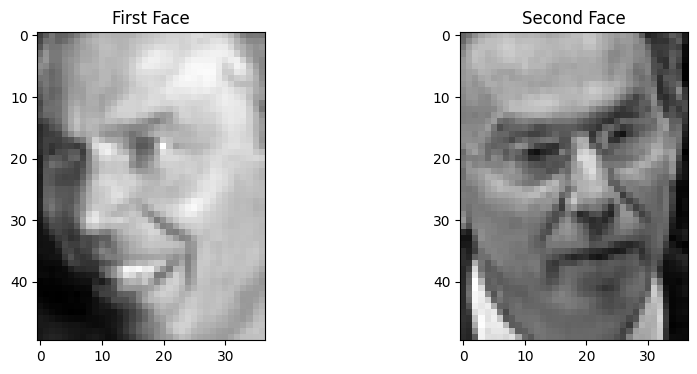

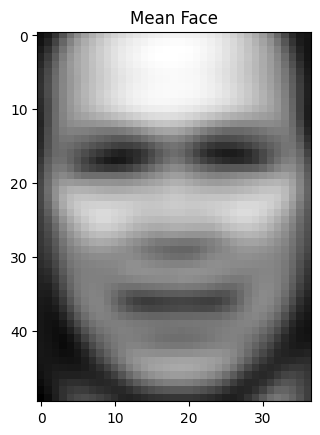

The 'average' face appears blurry, capturing common facial features without distinct details.


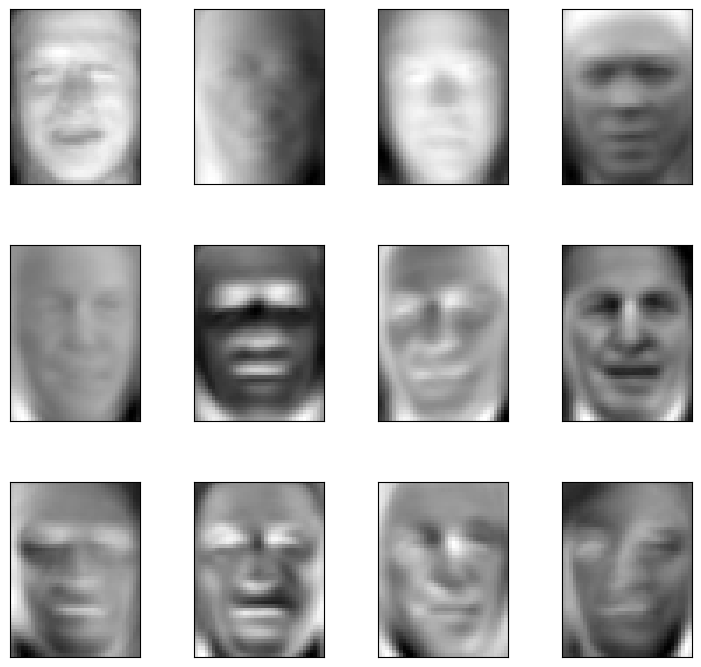

Displayed top 12 eigenfaces, which capture the directions of highest variance.


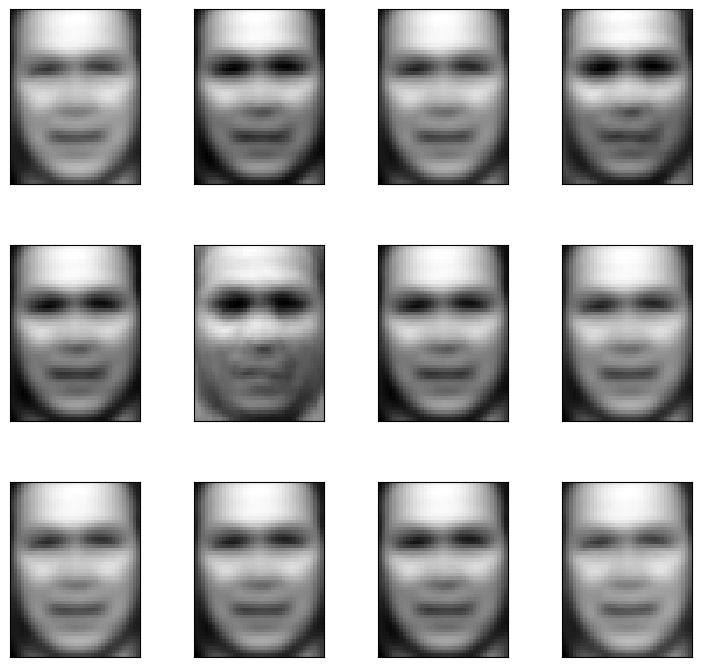

Reconstruction with 1 components completed.


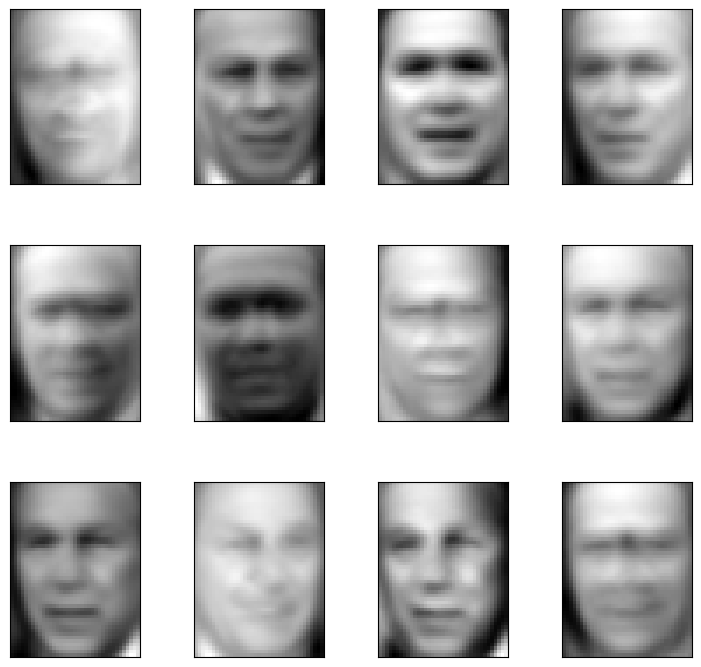

Reconstruction with 10 components completed.


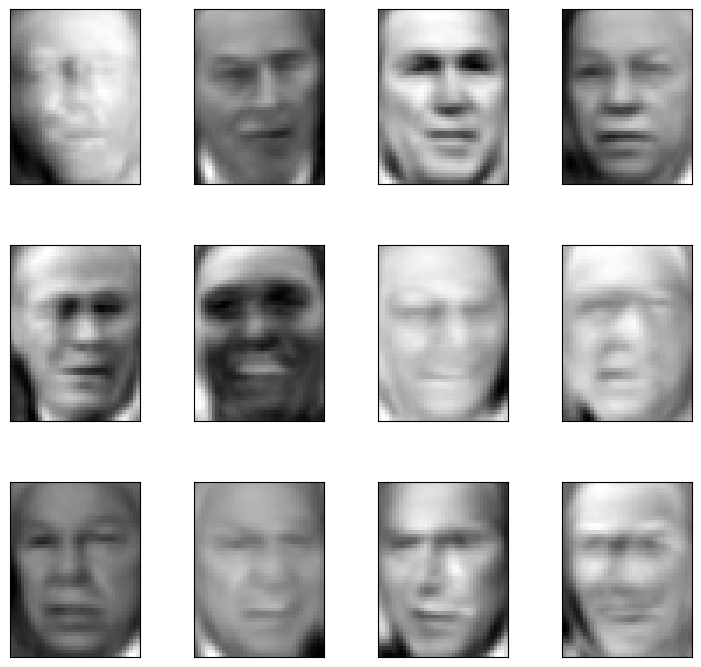

Reconstruction with 50 components completed.


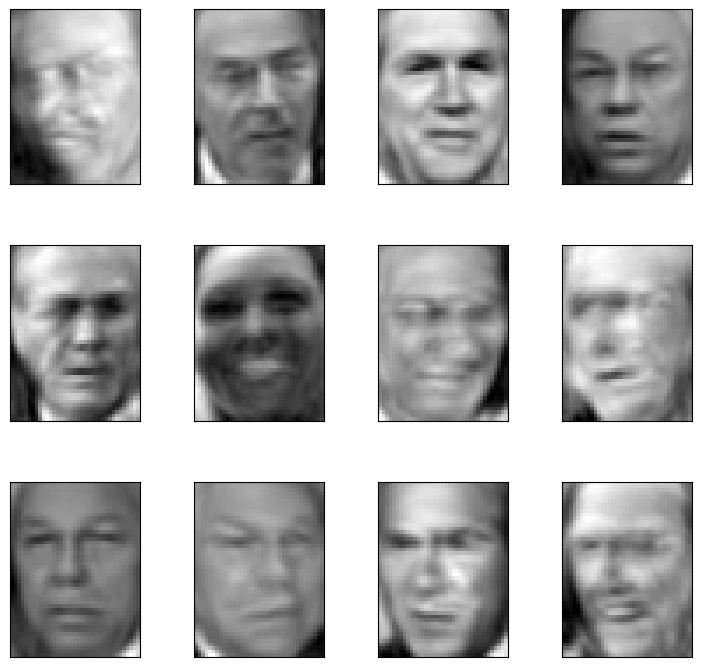

Reconstruction with 100 components completed.


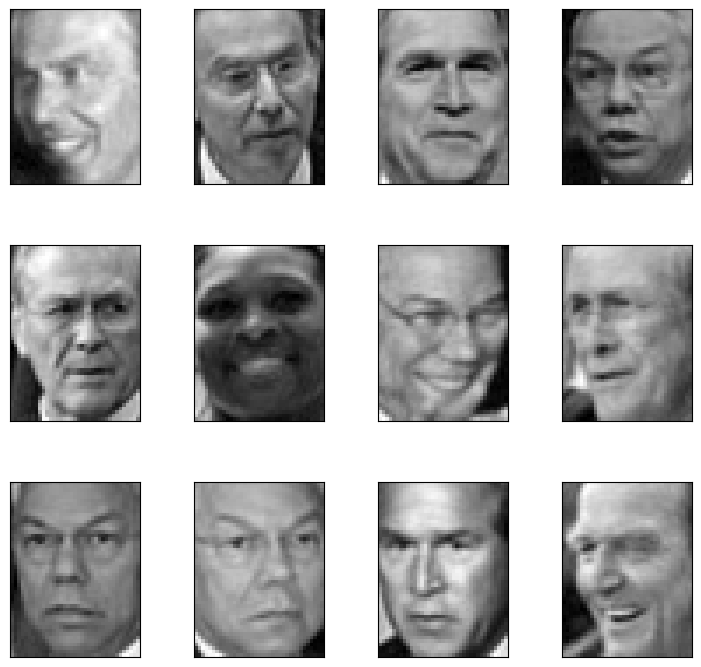

Reconstruction with 500 components completed.


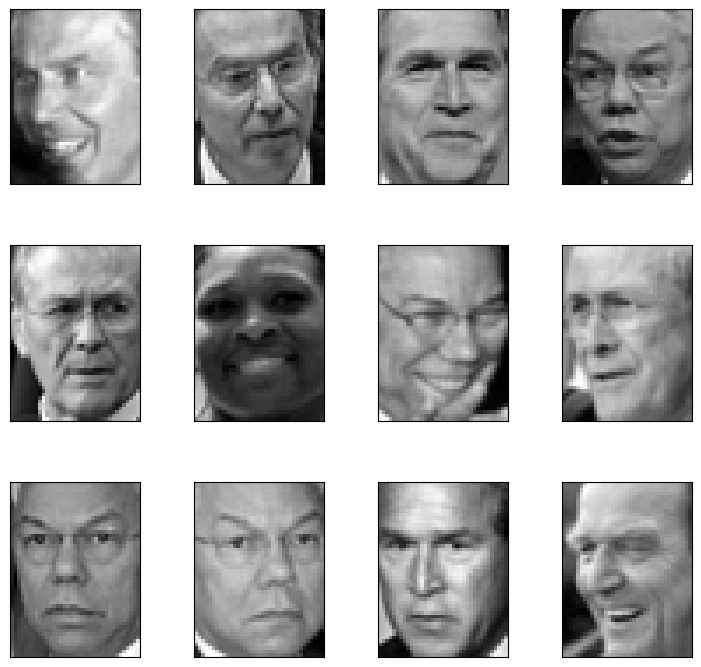

Reconstruction with 1288 components completed.
K-Means clustering on toy dataset (random init):


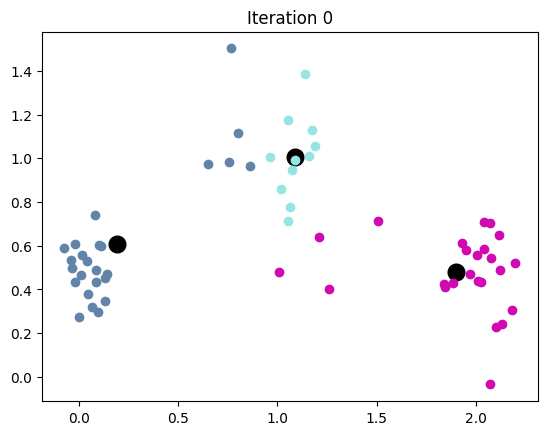

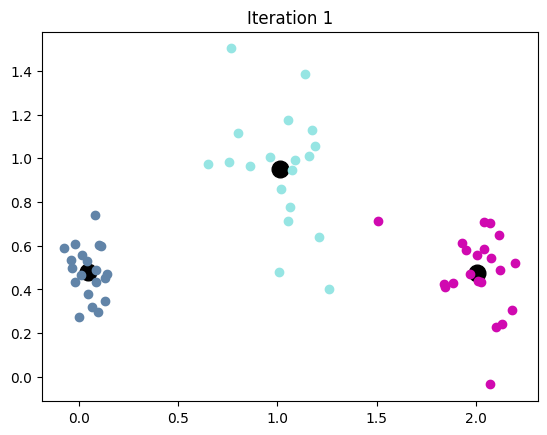

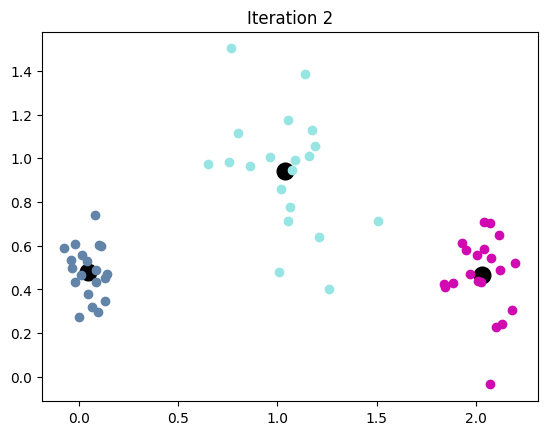

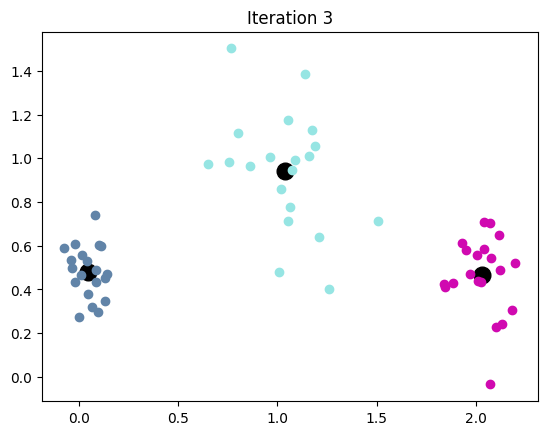

Final purity for k-Means (random init): 1.0
K-Medoids clustering on toy dataset (random init):


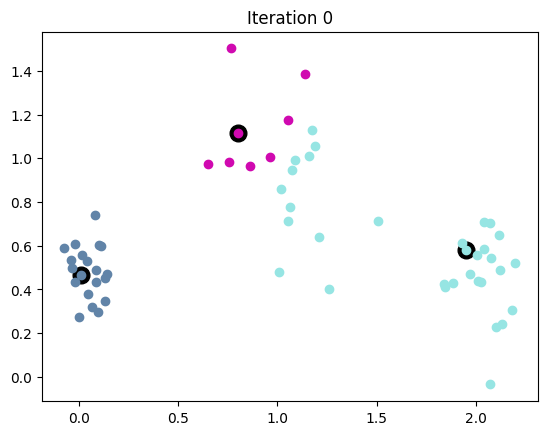

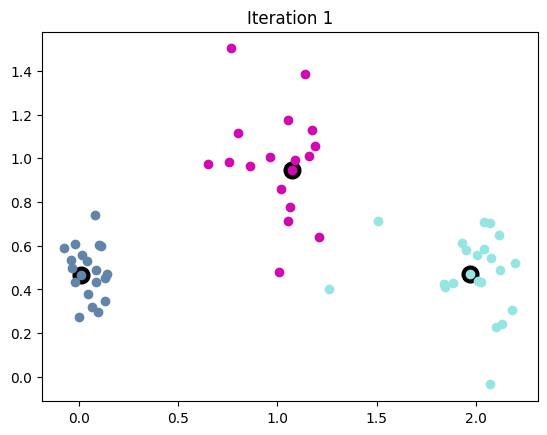

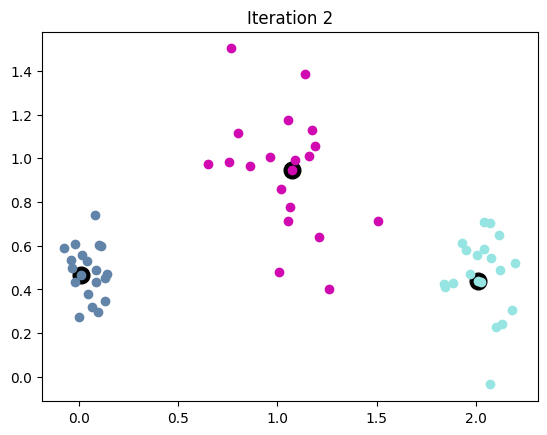

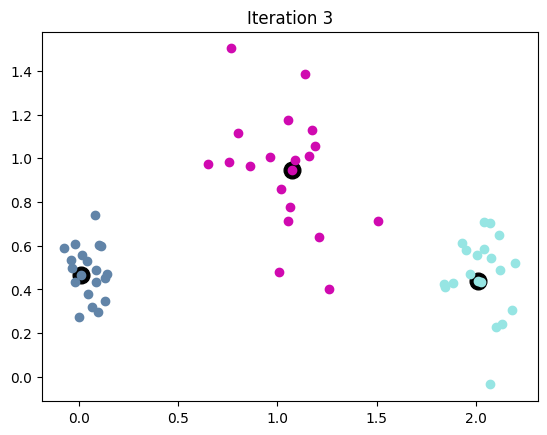

Final purity for k-Medoids (random init): 1.0
K-Means clustering on toy dataset (cheat init):


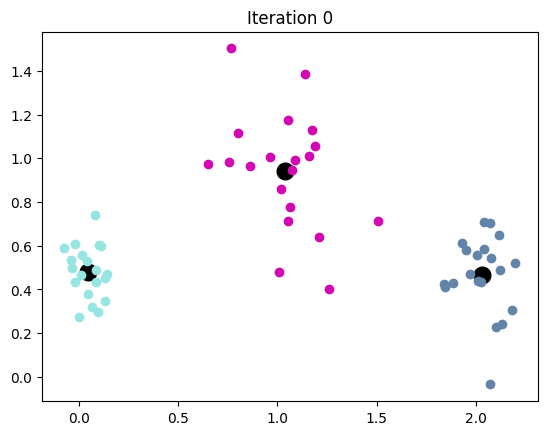

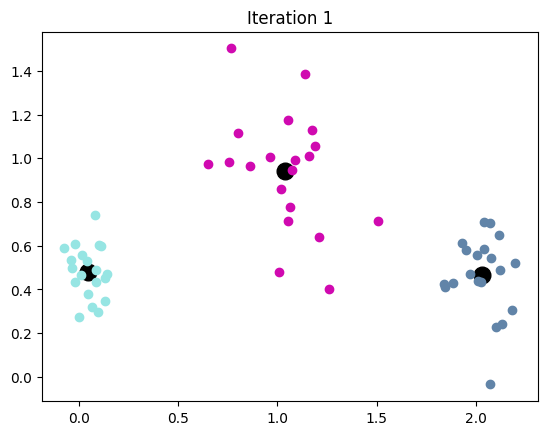

Final purity for k-Means (cheat init): 1.0
K-Medoids clustering on toy dataset (cheat init):


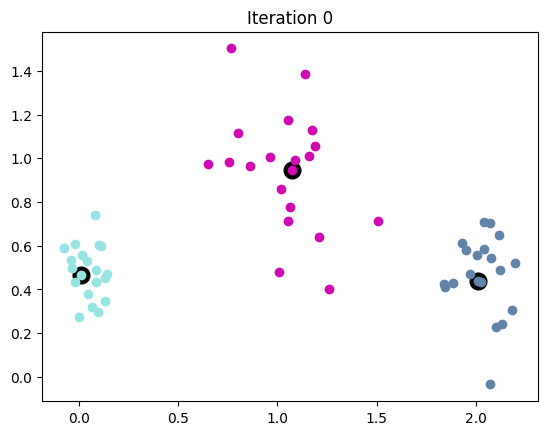

Final purity for k-Medoids (cheat init): 1.0
K-Means clustering on faces (4 classes): avg purity = 0.5831, min = 0.5188, max = 0.6875
K-Medoids clustering on faces (4 classes): avg purity = 0.6381, min = 0.5437, max = 0.7562


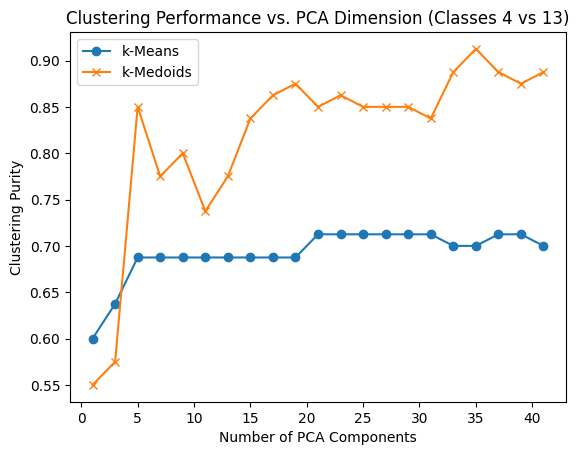

Purity for easy pair (classes 4, 16): 0.95


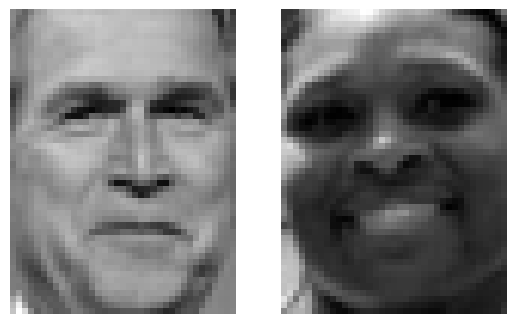

Purity for hard pair (classes 6, 13): 0.6


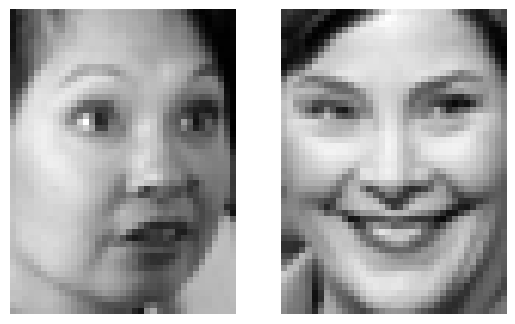

In [ ]:
######################################################################
# main
######################################################################

def main() :
    ### ========== TODO : START ========== ###
    # part 1: explore LFW data set
    # part a

    ## Use get_lfw_data(...) to get the LFW dataset with labels,

    # part b
    ## how the top twelve eigenfaces using PCA

    # part c
    ## compare the original image with the reconstructions

    # (a) Load the LFW dataset and display a couple of images.
    X, y = get_lfw_data()
    print("LFW data shape:", X.shape)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    img1 = vec_to_image(X[0])
    plt.imshow(img1, cmap='gray')
    plt.title("First Face")

    plt.subplot(1,2,2)
    img2 = vec_to_image(X[1])
    plt.imshow(img2, cmap='gray')
    plt.title("Second Face")
    plt.show()


    # Compute and display the mean face.
    mean_face = np.mean(X, axis=0)
    plt.figure()
    plt.imshow(vec_to_image(mean_face), cmap='gray')
    plt.title("Mean Face")
    plt.show()

    print("The 'average' face appears blurry, capturing common facial features without distinct details.")

    # (b) Perform PCA and display the top 12 eigenfaces.
    U, mu = PCA(X)
    top_eigenfaces = [vec_to_image(U[:, i]) for i in range(12)]
    plot_gallery(top_eigenfaces, title="Top 12 Eigenfaces")
    print("Displayed top 12 eigenfaces, which capture the directions of highest variance.")

    # (c) Compare original images with their reconstructions using varying numbers of PCA components.
    l_values = [1, 10, 50, 100, 500, 1288]  # 1288 equals total number of components.
    for l in l_values:
        # Note the changed order and unpacking here:
        X_proj, Ul = apply_PCA_from_Eig(X, U, l, mu)
        X_reconstructed = reconstruct_from_PCA(X_proj, Ul, mu)
        title_str = "Reconstruction with {} components".format(l)
        plot_gallery(X_reconstructed[:12], title=title_str)
        plt.show()
        print("Reconstruction with", l, "components completed.")

    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part 2d-2f: cluster toy dataset

    points_2d = generate_points_2d(N=20, seed=1234)

    # k-Means with random initialization.
    print("K-Means clustering on toy dataset (random init):")
    clusters_kmeans_rand = kMeans(points_2d, k=3, init='random', plot=True)
    print("Final purity for k-Means (random init):", clusters_kmeans_rand.score())

    # k-Medoids with random initialization.
    print("K-Medoids clustering on toy dataset (random init):")
    clusters_kmedoids_rand = kMedoids(points_2d, k=3, init='random', plot=True)
    print("Final purity for k-Medoids (random init):", clusters_kmedoids_rand.score())

    # k-Means with cheat initialization.
    print("K-Means clustering on toy dataset (cheat init):")
    clusters_kmeans_cheat = kMeans(points_2d, k=3, init='cheat', plot=True)
    print("Final purity for k-Means (cheat init):", clusters_kmeans_cheat.score())

    # k-Medoids with cheat initialization.
    print("K-Medoids clustering on toy dataset (cheat init):")
    clusters_kmedoids_cheat = kMedoids(points_2d, k=3, init='cheat', plot=True)
    print("Final purity for k-Medoids (cheat init):", clusters_kmedoids_cheat.score())


    ### ========== TODO : END ========== ###



    ### ========== TODO : START ========== ###
    # part 3a: cluster faces
    np.random.seed(1234) ## don't change the seed !!

    # --- 3a: Cluster faces with 4 classes ---
    # Select 40 images each from classes 4, 6, 13, and 16.
    X_faces, y_faces = limit_pics(X, y, [4, 6, 13, 16], 40)
    face_points = build_face_image_points(X_faces, y_faces)

    # Run clustering multiple times to measure purity.
    runs = 10
    purity_kmeans = []
    purity_kmedoids = []
    for _ in range(runs):
        clusters_km = kMeans(face_points, k=4, init='random', plot=False)
        clusters_md = kMedoids(face_points, k=4, init='random', plot=False)
        purity_kmeans.append(clusters_km.score())
        purity_kmedoids.append(clusters_md.score())

    print("K-Means clustering on faces (4 classes): avg purity = {:.4f}, min = {:.4f}, max = {:.4f}".format(
        np.mean(purity_kmeans), np.min(purity_kmeans), np.max(purity_kmeans)))
    print("K-Medoids clustering on faces (4 classes): avg purity = {:.4f}, min = {:.4f}, max = {:.4f}".format(
        np.mean(purity_kmedoids), np.min(purity_kmedoids), np.max(purity_kmedoids)))


    # part 3b: explore effect of lower-dimensional representations on clustering performance
    np.random.seed(1234) ## don't change the seed !!

    X_2classes, y_2classes = limit_pics(X, y, [4, 13], 40)
    face_points_2c = build_face_image_points(X_2classes, y_2classes)

    # Compute PCA on the entire dataset for projection.
    U_full, mu_full = PCA(X)
    l_vals = list(range(1, 42, 2))
    purity_kmeans_pca = []
    purity_kmedoids_pca = []
    for l in l_vals:
        # Project the two-class data into l dimensions.
        X_proj, Ul = apply_PCA_from_Eig(X_2classes, U_full, l, mu_full)
        # Build new Points with projected attributes.
        projected_points = [Point(face_points_2c[i].name, face_points_2c[i].label, X_proj[i, :])
                            for i in range(X_proj.shape[0])]
        clusters_km = kMeans(projected_points, k=2, init='cheat', plot=False)
        clusters_md = kMedoids(projected_points, k=2, init='cheat', plot=False)
        purity_kmeans_pca.append(clusters_km.score())
        purity_kmedoids_pca.append(clusters_md.score())

    plt.figure()
    plt.plot(l_vals, purity_kmeans_pca, marker='o', label='k-Means')
    plt.plot(l_vals, purity_kmedoids_pca, marker='x', label='k-Medoids')
    plt.xlabel("Number of PCA Components")
    plt.ylabel("Clustering Purity")
    plt.title("Clustering Performance vs. PCA Dimension (Classes 4 vs 13)")
    plt.legend()
    plt.show()


    # part 3c: determine ``most discriminative'' and ``least discriminative'' pairs of images
    np.random.seed(1234) ## don't change the seed !!

    X_easy, y_easy = limit_pics(X, y, [4, 16], 40)
    points_easy = build_face_image_points(X_easy, y_easy)
    clusters_easy = kMeans(points_easy, k=2, init='random', plot=False)
    print("Purity for easy pair (classes 4, 16):", clusters_easy.score())
    plot_representative_images(X_easy, y_easy, np.unique(y_easy))


    # Hard (less discriminative) pair:
    X_hard, y_hard = limit_pics(X, y, [6, 13], 40)
    points_hard = build_face_image_points(X_hard, y_hard)
    clusters_hard = kMeans(points_hard, k=2, init='random', plot=False)
    print("Purity for hard pair (classes 6, 13):", clusters_hard.score())
    plot_representative_images(X_hard, y_hard, np.unique(y_hard))



    ### ========== TODO : END ========== ###


if __name__ == "__main__" :
    main()